### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [30]:
# Constants:
H_0 = 73  # Hubble constant in km/s/Mpc
c =  c # Speed of light in m/s
G = G # Gravitational constant in pc kg^-1 (m/s)^2
q0=-0.534  # Deceleration parameter (assumed from Planck fit KEEP it as it is)()

Read the csv data into the python using the method below

In [31]:
df = pd.read_csv('Skyserver_SQL6_26_2025 3_38_22 PM.csv') # Download the data as instructed in the pdf
print(df.columns)
df.head()


Index(['objid', 'ra', 'dec', 'photoz', 'photozerr', 'specz', 'speczerr',
       'proj_sep', 'umag', 'umagerr', 'gmag', 'gmagerr', 'rmag', 'rmagerr',
       'obj_type', 'velocity'],
      dtype='object')


,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type,velocity
0,1.240000e+18,257.82458,64.133257,0.079193,0.022867,0.082447,0.000017,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3,2.471708e+07
1,1.240000e+18,257.82458,64.133257,0.079193,0.022867,0.082466,0.000014,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3,2.472278e+07
2,1.240000e+18,257.83332,64.126043,0.091507,0.014511,0.081218,0.000021,8.011259,20.22848,0.072019,18.38334,0.007763,17.46793,0.005828,3,2.434867e+07
3,1.240000e+18,257.85137,64.173247,0.081102,0.009898,0.079561,0.000022,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3,2.385181e+07
4,1.240000e+18,257.85137,64.173247,0.081102,0.009898,0.079568,0.000019,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3,2.385380e+07


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [32]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    1.000000
mean     0.081047
std           NaN
min      0.081047
25%      0.081047
50%      0.081047
75%      0.081047
max      0.081047
Name: specz, dtype: float64

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [55]:
print('Mean of redshift :', '%.5f' % df['specz'].mean()) # Mean of Redshift
print('Standard deviation of redshift :' , '%.5f' % df['specz'].std()) # Standard Deviation of Redshift

# Limits of Redshift by ( mean ± 3*sigma) rule
print('limits of redshift :','%.5f'%(df['specz'].mean() - 3*df['specz'].std()), 'to','%.5f'%(df['specz'].mean() + 3*df['specz'].std()))

Mean of redshift : 0.08105
Standard deviation of redshift : 0.00950
limits of redshift : 0.05255 to 0.10954


You can also use boxplot to visualize the overall values of redshift 

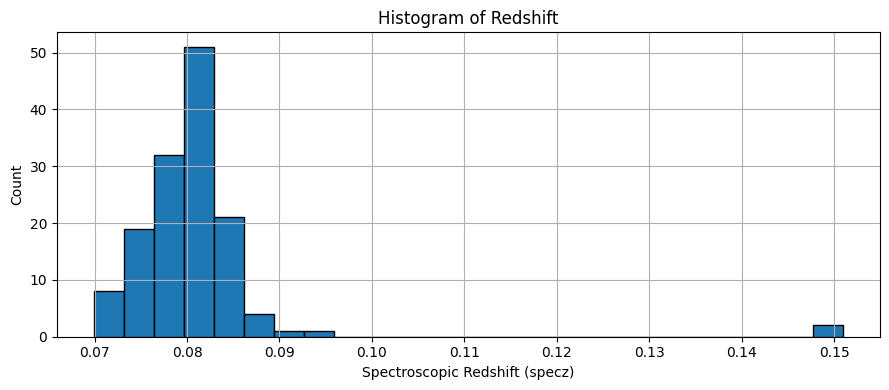

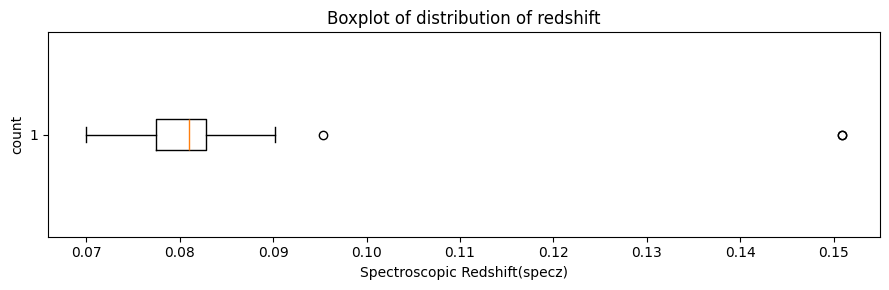

In [34]:
# Plot the distribution of redshift as histogram and a boxplot

# Histogram Plot
plt.figure(figsize=(9, 4))
plt.hist(df['specz'], bins=25, edgecolor='black')
plt.title('Histogram of Redshift')
plt.xlabel('Spectroscopic Redshift (specz)')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(9,3))
plt.boxplot(df['specz'], vert=False)
plt.title('Boxplot of distribution of redshift')
plt.ylabel('count')
plt.xlabel('Spectroscopic Redshift(specz)')
plt.tight_layout()
plt.show()


But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

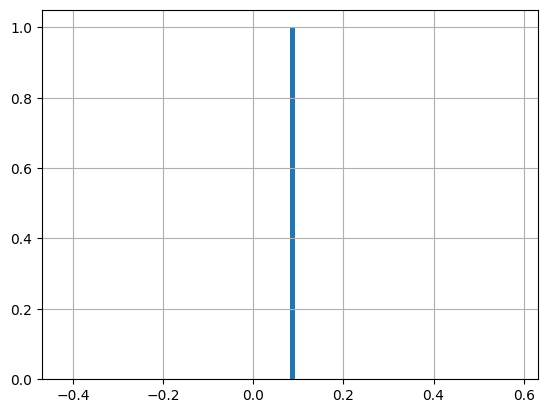

0    0.081047
Name: specz, dtype: float64


In [35]:
plt.hist(averaged_df['specz'],bins=90)
plt.grid()
plt.show()
print(averaged_df['specz'])

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [36]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
lower_lim = df['specz'].mean() - 3 * df['specz'].std()
upper_lim = df['specz'].mean() + 3 * df['specz'].std()

filtered_df = df[(df['specz'] >= lower_lim) & (df['specz'] <= upper_lim)]
print(f"Original data points: {len(df)}, After 3-sigma filter: {len(filtered_df)}")

Original data points: 139, After 3-sigma filter: 137


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [37]:
# z = v / c  using relation between redshift and velocity. v = z * c
velo = df['specz'] * c
df['velocity'] = velo # Assigning column name
df.to_csv('Skyserver_SQL6_26_2025 3_38_22 PM.csv', index=False) # Modifying existing data file

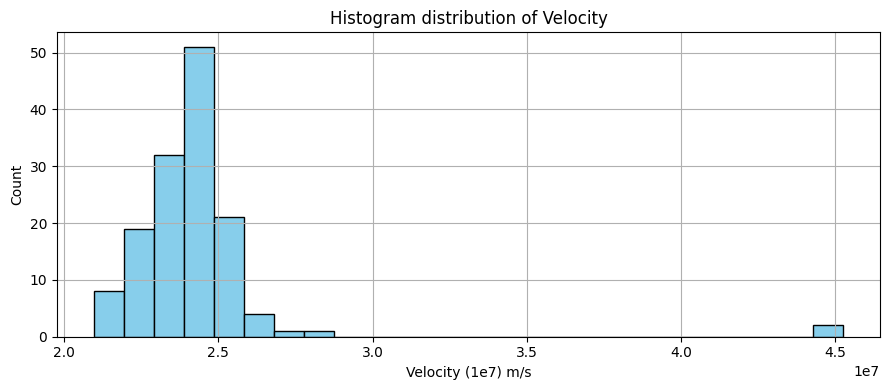

In [38]:
#plot the velocity column created as hist
plt.figure(figsize=(9, 4))
plt.hist(df['velocity'], bins=25, edgecolor='black', color='skyblue')
plt.title('Histogram distribution of Velocity')
plt.xlabel('Velocity (1e7) m/s')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(True)
plt.show()


use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [39]:
cluster_redshift = filtered_df['specz'].mean()
dispersion = c.to('km/s') * ((1 + filtered_df['specz'])**2 - (1 + cluster_redshift)**2) / ((1 + filtered_df['specz'])**2 + (1 + cluster_redshift)**2)

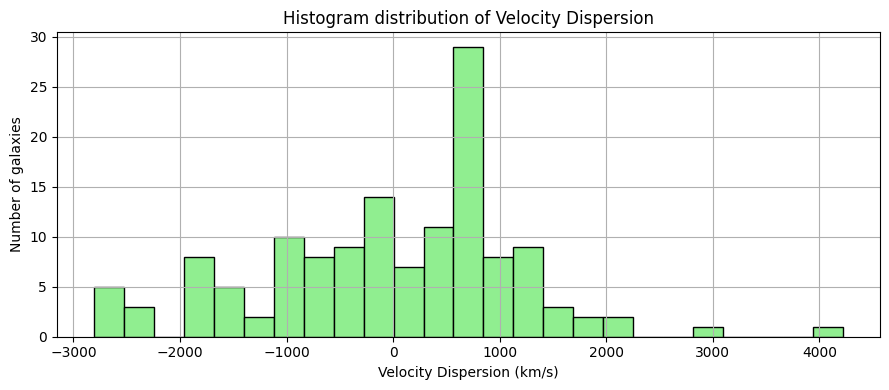

In [40]:
#plot the velocity dispersion histogram
plt.figure(figsize=(9, 4))
plt.hist(dispersion, bins=25, edgecolor='black', color='lightgreen')
plt.title('Histogram distribution of Velocity Dispersion')
plt.xlabel('Velocity Dispersion (km/s)')
plt.ylabel('Number of galaxies')
plt.tight_layout()
plt.grid(True)
plt.show() 

Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [41]:
print(pd.Series(dispersion).describe())
disp = dispersion.std()

count     137.000000
mean       -2.392825
std      1202.576295
min     -2803.471718
25%      -763.070775
50%       248.411265
75%       767.132350
max      4217.366753
Name: specz, dtype: float64


In [42]:

print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4f} km/s.")

The value of the cluster redshift = 0.08003
The characteristic value of velocity dispersion of the cluster along the line of sight = 1202.5763 km/s.


In [43]:
 # projected separation data in arcmin
df['proj_sep'] # for all galaxy
print(df['proj_sep'].describe())

# projected separation of filtered data
filtered_df['proj_sep'] # in arcmin

# filtered projected separation in radians
theta_rad = filtered_df['proj_sep'] * (np.pi / 180 / 60)


count    139.000000
mean       6.079801
std        2.517581
min        0.429175
25%        4.045745
50%        6.405518
75%        8.347733
max        9.844519
Name: proj_sep, dtype: float64


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



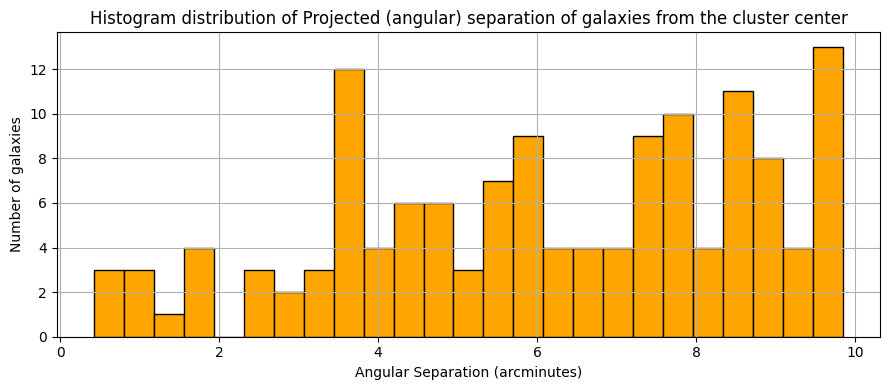

In [44]:
#Plot histogram for proj sep column
plt.figure(figsize=(9,4))
plt.hist(filtered_df['proj_sep'], bins=25, edgecolor='black', color='orange')
plt.title('Histogram distribution of Projected (angular) separation of galaxies from the cluster center')
plt.xlabel('Angular Separation (arcminutes)')
plt.ylabel('Number of galaxies')
plt.tight_layout()
plt.grid(True)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [45]:
# co-moving distance (Mpc)
r = (c.to('km/s') * filtered_df['specz'] / H_0) * (1 - (filtered_df['specz'] * (1 + q0)) / 2) # in Mpc

# ra angular diameter distance (Mpc)
ra = r / (1 + filtered_df['specz'])

# Diameter (in Mpc) for each filtered galaxy
diameter = ra * theta_rad 

# Maximum diameter of cluster
cluster_diameter = diameter.max()
print(f"Cluster Diameter: {cluster_diameter:.3f} Mpc")

Cluster Diameter: 0.919 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [46]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((disp*1000)**2)*(cluster_diameter * 0.5 * 1e6 * 3e16)/(G.value * 2e30)

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 4.48e+14 solar mass


In [ ]:
# Calculating luminosity mass of cluster

# r-band absolute magnitude of sun
rmag_sun = 4.64 

# Calculating luminosity distance in parsec
L_d = cosmo.luminosity_distance(filtered_df['specz']).to('pc').value

# Formuala for absolute magnitude M = m - 5log10(L_d/10)
# where, M = absolute magnitude, m = apparent magnitude, L_d = distance in parsec
A_m = filtered_df['rmag'] - 5 * np.log10(L_d/10)

# Calculating luminosity in solar units
L = 10**(0.4 * (rmag_sun - A_m))

# Assume mass to light ratio
m_l_ratio = 2.0

# Estimate stellar mass for each galaxy
stellar_mass = m_l_ratio * L

# Total luminous mass in solar masses
luminous_mass = stellar_mass.sum()
print(f"Total luminous mass: {luminous_mass:.2e} solar mass")

# Stellar mass fraction # typically around 1-3% for galaxy clusters
print(f"Stellar mass fraction = {(luminous_mass/M_dyn):.4f} ~ {((luminous_mass/M_dyn)*100):.4f} %")

Total luminous mass: 7.42e+12 solar mass
Stellar mass fraction = 0.0166 ~ 1.6565 %
